# Backtesting a Momentum Trading Strategy

## 1. Problem

We aim to apply a trading strategy based only on the history of past prices, or momentum strategy: buys the previous winners (i.e. stocks with the highest returns in the recent past) and sells the losers (i.e., stocks with the lowest past returns).

We will use a "classical" machine learning and deep learning model. One problem we face is the noise of the stock data; therefore we'll need to avoid overfitting on the training set.

**Please see the Report for the complete picture of the project.**

## 2. Getting the data

In [57]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
from datetime import datetime
from sklearn.linear_model import LogisticRegression
import math
import seaborn as sns
import time
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
import tensorflow as tf
from tensorflow.python.framework import ops
from functools import partial

The data was provided and it contains stock market data fo approximately 1500 securities listed on the US stock exchange. We'll work with daily data from February 2018 to July 2017. 

In [58]:
data=pd.read_csv("./final_project_data.csv")
data=data.dropna()
data.index=range(len(data))

In [59]:
data.shape

(3547259, 43)

In [60]:
data.columns

Index(['date', 'id', 'industry', 'ret_raw', 'flag', 'ret_20_raw', 'flag2',
       'ret_raw_norm', 'ret_20_raw_norm', 'ret_raw_norm_lag_21',
       'ret_raw_norm_lag_22', 'ret_raw_norm_lag_23', 'ret_raw_norm_lag_24',
       'ret_raw_norm_lag_25', 'ret_raw_norm_lag_26', 'ret_raw_norm_lag_27',
       'ret_raw_norm_lag_28', 'ret_raw_norm_lag_29', 'ret_raw_norm_lag_30',
       'ret_raw_norm_lag_31', 'ret_raw_norm_lag_32', 'ret_raw_norm_lag_33',
       'ret_raw_norm_lag_34', 'ret_raw_norm_lag_35', 'ret_raw_norm_lag_36',
       'ret_raw_norm_lag_37', 'ret_raw_norm_lag_38', 'ret_raw_norm_lag_39',
       'ret_raw_norm_lag_40', 'ret_20_raw_norm_lag_41_60',
       'ret_20_raw_norm_lag_61_80', 'ret_20_raw_norm_lag_81_100',
       'ret_20_raw_norm_lag_101_120', 'ret_20_raw_norm_lag_121_140',
       'ret_20_raw_norm_lag_141_160', 'ret_20_raw_norm_lag_161_180',
       'ret_20_raw_norm_lag_181_200', 'ret_20_raw_norm_lag_201_220',
       'ret_20_raw_norm_lag_221_240', 'ret_20_raw_norm_lag_241_260',
   

In [61]:
data.head()

,date,id,industry,ret_raw,flag,ret_20_raw,flag2,ret_raw_norm,ret_20_raw_norm,ret_raw_norm_lag_21,...,ret_20_raw_norm_lag_121_140,ret_20_raw_norm_lag_141_160,ret_20_raw_norm_lag_161_180,ret_20_raw_norm_lag_181_200,ret_20_raw_norm_lag_201_220,ret_20_raw_norm_lag_221_240,ret_20_raw_norm_lag_241_260,ret_20_raw_norm_lag_261_280,isJan,target
0,20080214,A US Equity,3520,-0.034888,True,-0.115785,False,-0.626602,-1.155291,-0.342618,...,-0.927360,0.184879,0.157539,1.093994,-0.189996,0.915039,-0.259174,-1.240792,0.0,0.0
1,20080214,AA US Equity,1510,-0.004224,True,0.160461,False,0.538586,1.116039,-0.616964,...,-0.811019,0.657379,-0.466201,1.449841,0.170922,0.042121,0.339868,1.037797,0.0,1.0
2,20080214,AAN US Equity,2550,0.000000,True,0.102639,False,0.699089,0.640614,0.803338,...,1.306399,-2.065115,0.532074,-0.593705,0.523305,-0.527815,-1.058531,0.101127,0.0,1.0
3,20080214,AAON US Equity,2010,-0.046684,True,0.013005,False,-1.074841,-0.096364,-0.091706,...,0.782537,-0.145668,1.478548,1.629201,-1.186070,-1.054264,0.029782,0.089869,0.0,0.0
4,20080214,AAP US Equity,2550,-0.040387,True,0.064812,False,-0.835580,0.329595,0.635282,...,-0.844002,-0.495810,-0.335421,-0.517209,0.466003,0.442235,-0.078167,0.179575,0.0,1.0


### 33 Model Input Features (momentum driven features):


'ret_raw_norm_lag_21',
'ret_raw_norm_lag_22', 'ret_raw_norm_lag_23', 'ret_raw_norm_lag_24',
'ret_raw_norm_lag_25', 'ret_raw_norm_lag_26', 'ret_raw_norm_lag_27',
'ret_raw_norm_lag_28', 'ret_raw_norm_lag_29', 'ret_raw_norm_lag_30',
'ret_raw_norm_lag_31', 'ret_raw_norm_lag_32', 'ret_raw_norm_lag_33',
'ret_raw_norm_lag_34', 'ret_raw_norm_lag_35', 'ret_raw_norm_lag_36',
'ret_raw_norm_lag_37', 'ret_raw_norm_lag_38', 'ret_raw_norm_lag_39',
'ret_raw_norm_lag_40', 'ret_20_raw_norm_lag_41_60',
'ret_20_raw_norm_lag_61_80', 'ret_20_raw_norm_lag_81_100',
'ret_20_raw_norm_lag_101_120', 'ret_20_raw_norm_lag_121_140',
'ret_20_raw_norm_lag_141_160', 'ret_20_raw_norm_lag_161_180',
'ret_20_raw_norm_lag_181_200', 'ret_20_raw_norm_lag_201_220',
'ret_20_raw_norm_lag_221_240', 'ret_20_raw_norm_lag_241_260',
'ret_20_raw_norm_lag_261_280', 'isJan',



## 3. Exploring the dataset

**Ratio of longs per year**

We present the proportion of bets per year involved in long positions. A value close to 0.5 is considered a long-short strategy. The year 2008 has surprisingly had the highest percentage of long positions.

In [62]:
ratio=[]
for i in range (2008,2017):
    d=data[(data.date<=int(str(i)+'1231'))&(data.date>=int(str(i)+'0101'))]
    y=d['target'].sum()/len(d)
    ratio.append(y)
    print("Year={}, ratio of longs={}".format(i,y))

Year=2008, ratio of longs=0.5024824980227892
Year=2009, ratio of longs=0.49712552218022676
Year=2010, ratio of longs=0.4991963365075514
Year=2011, ratio of longs=0.5012819544983043
Year=2012, ratio of longs=0.49859481800255884
Year=2013, ratio of longs=0.49762012866099714
Year=2014, ratio of longs=0.49966623540235017
Year=2015, ratio of longs=0.5000853069204663
Year=2016, ratio of longs=0.4997055365890532


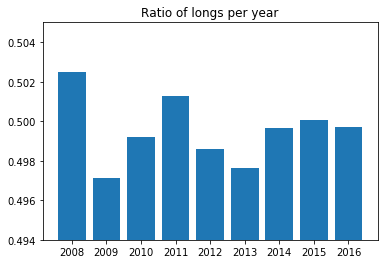

In [63]:
year = ('2008','2009','2010','2011','2012','2013','2014','2015', '2016')
plt.bar(year, ratio)
plt.title('Ratio of longs per year')
plt.ylim([0.494,0.505])
plt.show()

Distribution of returns

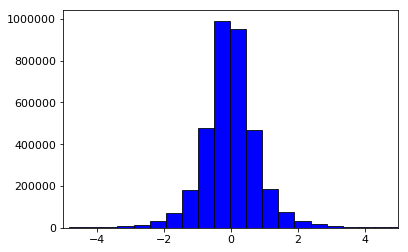

In [64]:
data["ret_raw_norm"].hist(bins=150, color='blue', edgecolor='black', linewidth=0.8, xlabelsize=11, ylabelsize=11, grid=False)
plt.xlim([-5,5])
plt.show()

Frequency of bets: number of bets for long positions every 20 days

In [10]:
long=[]
short=[]
for i in range (2008,2017):
    d=data[(data.date<=int(str(i)+'1231'))&(data.date>=int(str(i)+'0101'))]
    l=(d['target']*d['flag2']).sum()
    s=d['flag2'].sum()-l
    long.append(l)
    short.append(s)
    print("Year={}, number of bets: Long={} and Short={}".format(i,l,s))

Year=2008, number of bets: Long=6747.0 and Short=6696.0
Year=2009, number of bets: Long=7157.0 and Short=7247.0
Year=2010, number of bets: Long=8469.0 and Short=8526.0
Year=2011, number of bets: Long=8537.0 and Short=8498.0
Year=2012, number of bets: Long=9586.0 and Short=9618.0
Year=2013, number of bets: Long=10071.0 and Short=10164.0
Year=2014, number of bets: Long=9841.0 and Short=9797.0
Year=2015, number of bets: Long=11194.0 and Short=11160.0
Year=2016, number of bets: Long=10555.0 and Short=10566.0


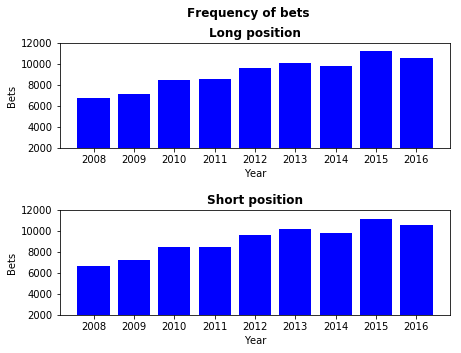

In [11]:
# Create a figure
fig = plt.figure(figsize=(7,5))
_ = plt.subplots_adjust(wspace = 0.4, hspace = 0.6 )
fig.suptitle('Frequency of bets', fontweight="bold")

# Create a plot of price over time
ax = fig.add_subplot(2, 1, 1)
_ = ax.bar(year, long, color="blue")
_=ax.set_ylim([2000,12000])
_ = ax.set_title("Long position", fontweight="bold")
_ = ax.set_xlabel("Year"); _ = ax.set_ylabel("Bets")
    
# Create a plot of price over time
ax = fig.add_subplot(2, 1, 2)
_ = ax.bar(year, short, color="blue")
_=ax.set_ylim([2000,12000])
_ = ax.set_title("Short position", fontweight="bold")
_ = ax.set_xlabel("Year"); _ = ax.set_ylabel("Bets")

## 4. Select a model

### Logistic Regression - Baseline Strategy
Use 5 years data for training and subsequent 1 year data for testing

In [15]:
def strategy_train(model, date_n):
    
    """ 
    Parameters
    ----------
    model ->  Model used to train the data
    date_n -> Introduce the year 2012 to train the data between 2008-2012
           
    Returns
    --------
    The probabilities of the training set 2008-2012
    
    """    
     
    train=data[(data.date<=int(str(date_n)+'1231'))&(data.date>=int(str(date_n-4)+'0101'))]
    train=train.dropna()
    train.index=range(len(train))
    #globals()['train_{}'.format(i)]=train.copy()
    
    test=data[(data.date<=int(str(date_n+1)+'1231'))&(data.date>=int(str(date_n+1)+'0101'))]
    test=test.dropna()
    test.index=range(len(test))
    #globals()['test_{}'.format(i)]=test.copy() 
    
    X_train=np.asarray(train.loc[:,'ret_raw_norm_lag_21':'isJan'])
    Y_train=np.asarray(train.loc[:,'target'])
    
    X_test=np.asarray(test.loc[:,'ret_raw_norm_lag_21':'isJan'])
    Y_test=np.asarray(test.loc[:,'target'])
    
    clf=model
    clf.fit(X_train, Y_train)
    #res=pd.concat((test.loc[:,['id','date','target']], pd.DataFrame(clf.predict_proba(X_test))),axis=1)
    res=pd.concat((train.loc[:,['id','date','target']], pd.DataFrame(clf.predict_proba(X_train))),axis=1) # in_sample
    res.columns=["id","date",'target',"pred_zsprob_comp","Alp"]
    res.index=range(len(res))
    globals()["result_{}".format(date_n)]=res.copy()
    print("result_{}".format(date_n))
    acc_os=1.0*(clf.predict(X_test)==np.asarray(Y_test)).sum()/len(Y_test)
    acc_in=1.0*(clf.predict(X_train)==np.asarray(Y_train)).sum()/len(Y_train)
    print ('\033[1m' "Out of sample accuracy: {}".format((acc_os)*100))
    print ('\033[1m' "In sample accuracy: {}".format((acc_in)*100))
        
    return 

In [16]:
model=LogisticRegression(n_jobs=-1, solver='lbfgs')
strategy_train(model, 2012)

result_2012
Out of sample accuracy: 49.48831490824869
In sample accuracy: 51.75502135023703


In [17]:
def strategy_test(model,date_n):
    
    """ 
    Parameters
    ----------
    model ->  Model used to train the data
    date_n -> Introduce a year from 2013 onwards
           
    Returns
    --------
    The probabilities of the selected testing set (2013-2017)
    
    """   
    
    train=data[(data.date<=int(str(date_n)+'1231'))&(data.date>=int(str(date_n-4)+'0101'))]
    train=train.dropna()
    train.index=range(len(train))
    #globals()['train_{}'.format(i)]=train.copy()
    
    test=data[(data.date<=int(str(date_n+1)+'1231'))&(data.date>=int(str(date_n+1)+'0101'))]
    test=test.dropna()
    test.index=range(len(test))
    #globals()['test_{}'.format(i)]=test.copy() 
    
    X_train=np.asarray(train.loc[:,'ret_raw_norm_lag_21':'isJan'])
    Y_train=np.asarray(train.loc[:,'target'])
    
    X_test=np.asarray(test.loc[:,'ret_raw_norm_lag_21':'isJan'])
    Y_test=np.asarray(test.loc[:,'target'])
    
    clf=model
    clf.fit(X_train, Y_train)
    res=pd.concat((test.loc[:,['id','date','target']], pd.DataFrame(clf.predict_proba(X_test))),axis=1)
    #res=pd.concat((train.loc[:,['id','date','target']], pd.DataFrame(clf.predict_proba(X_train))),axis=1) # in_sample
    res.columns=["id","date",'target',"pred_zsprob_comp","Alp"]
    res.index=range(len(res))
    globals()["result_{}".format(date_n+1)]=res.copy()
    print("result_{}".format(date_n+1))
    acc_os=1.0*(clf.predict(X_test)==np.asarray(Y_test)).sum()/len(Y_test)
    acc_in=1.0*(clf.predict(X_train)==np.asarray(Y_train)).sum()/len(Y_train)
    print ('\033[1m' "Out of sample accuracy: {}".format((acc_os)*100))
    print ('\033[1m' "In sample accuracy: {}".format((acc_in)*100))
        
    return

In [18]:
model=LogisticRegression(n_jobs=-1, solver='lbfgs')
for i in range(2012,2017):
    strategy_test(model,i)

result_2013
Out of sample accuracy: 49.48831490824869
In sample accuracy: 51.75502135023703
result_2014
Out of sample accuracy: 50.39408496311598
In sample accuracy: 51.690981849004835
result_2015
Out of sample accuracy: 51.460362254684966
In sample accuracy: 51.62030084277889
result_2016
Out of sample accuracy: 49.355903596515176
In sample accuracy: 51.796276308551306
result_2017
Out of sample accuracy: 51.82824126388505
In sample accuracy: 51.481921277275354


In [20]:
RES=result_2012
for i in range(2012,2018):
    RES=pd.concat((RES,globals()["result_{}".format(i)]),axis=0)

tt=RES.merge(data.loc[:,["id","date","ret_raw","ret_20_raw","industry","flag2"]],left_on=["date","id"],right_on=["date","id"],how="left")

### Random Forest


Overall:

- The more trees the less likely the algorithm is to overfit.

- Increasing the maximum depth of a tree make the model more complex and more likely to overfit. 

- The run time for a randomized search is drastically lower.

- Dealing with financial data is extremely complicated. It’s easy to overfit.

<div class="alert alert-block alert-info">
    <b>Finding the optimal hyperparameters:</b> 
    <ul>
        <li>I used a RandomizedSearchCV technique to narrow my search for optimal hyperparameters, then I used a hold-out strategy and choose the model with the highest accuracy. I presented the code for the training set 2008-2012, you can find the other years in the zip file under the name R2, R3, R4 and R5, since I ran the code for each year on a different notebook to decrease the time of waiting.</li>

</div>

In [15]:
rf= RandomForestClassifier(random_state = 99, class_weight= "balanced_subsample")
print(rf.get_params())n_estimators = [int(x) for x in np.linspace(start = 45, stop = 105, num = 15)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(4, 8, num = 5)]

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

{'bootstrap': True, 'class_weight': 'balanced_subsample', 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 'warn', 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}


In [16]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 45, stop = 105, num = 15)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(4, 8, num = 5)]

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

#Grid
random_grid = {'n_estimators': n_estimators,'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}
print(random_grid)

{'n_estimators': [45, 49, 53, 57, 62, 66, 70, 75, 79, 83, 87, 92, 96, 100, 105], 'max_features': ['auto', 'sqrt'], 'max_depth': [4, 5, 6, 7, 8], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}


<div class="alert alert-info" role="alert">
  <strong>Trainig set: 2008-2012.</strong> 
</div>

In [8]:
#First training set: 2008-2012
i=2012

train_rf=data[(data.date<=int(str(i)+'1231'))&(data.date>=int(str(i-4)+'0101'))]
train_rf=train_rf.dropna()
X_train_rf=np.asarray(train_rf.loc[:,'ret_raw_norm_lag_21':'isJan'])
Y_train_rf=np.asarray(train_rf.loc[:,'target'])

rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, cv = 5, verbose=2, random_state=99, n_jobs = -1, pre_dispatch=500)
rf_random.fit(X_train_rf, Y_train_rf)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  19 out of  50 | elapsed: 89.1min remaining: 145.4min
[Parallel(n_jobs=-1)]: Done  45 out of  50 | elapsed: 216.9min remaining: 24.1min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 234.9min finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced_subsample',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators='warn', n_jobs=None, oob_score=False,
            random_state=42, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=10, n_jobs=-1,
          param_distributions={'n_estimators': [45, 49, 53, 57, 62, 66, 70, 75, 79, 83, 87, 92, 96, 100, 105], 'max_features': ['auto', 'sqrt'], 'max_depth': [4, 5, 6, 7, 8], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]},
          pre_dispatch=500, random_state=42, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

In [9]:
rf_random.best_params_

{'n_estimators': 83,
 'min_samples_split': 2,
 'min_samples_leaf': 4,
 'max_features': 'sqrt',
 'max_depth': 7}

**Validation score**

In [26]:
X_train_,X_vali_,Y_train_,Y_vali_ = train_test_split(X_train_rf, Y_train_rf, test_size=0.1, random_state=99)

best_score = 0
n_estimators = [int(x) for x in np.linspace(start = 80, stop = 90, num = 7)]
max_depth = [int(x) for x in np.linspace(6, 8, num = 3)]
for n in n_estimators:
    for d in max_depth:
        clf =  RandomForestClassifier(random_state = 99, class_weight= "balanced_subsample", n_estimators= n,
        min_samples_split= 2, min_samples_leaf= 4, max_features='sqrt', max_depth=d)
        clf.fit(X_train_,Y_train_) 
        score = clf.score(X_vali_, Y_vali_)
        if score > best_score:
            best_score = score
        print ("Score:", score, "n_estimator= ", n, "Max_depth=",d )

Score: 0.5236787920384351 n_estimator=  80 Max_depth= 6
Score: 0.5266999215609374 n_estimator=  80 Max_depth= 7
Score: 0.5297394352387489 n_estimator=  80 Max_depth= 8
Score: 0.523740072556133 n_estimator=  81 Max_depth= 6
Score: 0.5268653789587214 n_estimator=  81 Max_depth= 7
Score: 0.5298068438082165 n_estimator=  81 Max_depth= 8
Score: 0.5235746151583489 n_estimator=  83 Max_depth= 6
Score: 0.5269450436317286 n_estimator=  83 Max_depth= 7
Score: 0.5297823316011374 n_estimator=  83 Max_depth= 8
Score: 0.5242732130601039 n_estimator=  85 Max_depth= 6
Score: 0.5267121776644769 n_estimator=  85 Max_depth= 7
Score: 0.5298313560152956 n_estimator=  85 Max_depth= 8
Score: 0.5240280909893127 n_estimator=  86 Max_depth= 6
Score: 0.527410775566232 n_estimator=  86 Max_depth= 7
Score: 0.5297087949799 n_estimator=  86 Max_depth= 8
Score: 0.5237523286596725 n_estimator=  88 Max_depth= 6
Score: 0.5270859888224336 n_estimator=  88 Max_depth= 7
Score: 0.5296781547210511 n_estimator=  88 Max_depth=

Selecting the parameters asssociated with the highest valdiation score. Note that I won't select this model becuase of the depth and number of estimators are prone to overfit the model.

In [29]:
test_rf=data[(data.date<=int(str(i+1)+'1231'))&(data.date>=int(str(i+1)+'0101'))]  
test_rf=test_rf.dropna()
X_test_rf=np.asarray(test_rf.loc[:,'ret_raw_norm_lag_21':'isJan'])
Y_test_rf=np.asarray(test_rf.loc[:,'target'])

clf =  RandomForestClassifier(random_state = 99, class_weight= "balanced_subsample", n_estimators= 90,
min_samples_split= 2, min_samples_leaf= 4, max_features='sqrt', max_depth=8, n_jobs=-1)
clf.fit(X_train_rf,Y_train_rf) 

acc_os=1.0*(clf.predict(X_test_rf)==np.asarray(Y_test_rf)).sum()/len(Y_test_rf)
acc_in=1.0*(clf.predict(X_train_rf)==np.asarray(Y_train_rf)).sum()/len(Y_train_rf)
print ('\033[1m' "Out of sample accuracy: {}".format((acc_os)*100))
print ('\033[1m' "In sample accuracy: {}".format((acc_in)*100))

Out of sample accuracy: 50.065554869680994
In sample accuracy: 54.40462008343996


<div class="alert alert-success" role="alert">
  <strong>Success! Repeat same steps to get the best model for every year!</strong> You can find the other files to get the best model for each year in the zip file (I ran those notebooks on another computer to speed up the things).
</div>

**Best Models using Random Forest**

In [65]:
model_2012=  RandomForestClassifier(random_state = 99, class_weight= "balanced_subsample", n_estimators= 83,
min_samples_split= 2, min_samples_leaf= 4, max_features='sqrt', max_depth=7, n_jobs=-1)

strategy_train(model_2012, 2012)

result_2012
Out of sample accuracy: 50.05586193175151
In sample accuracy: 53.63726167889832


In [66]:
model_2013=RandomForestClassifier(random_state = 99, class_weight= "balanced_subsample", n_estimators= 50,
min_samples_split= 5, min_samples_leaf= 2, max_features='sqrt', max_depth=8, n_jobs=-1)

model_2014=RandomForestClassifier(random_state = 99, class_weight= "balanced_subsample", n_estimators= 83,
min_samples_split= 2, min_samples_leaf= 4, max_features='sqrt', max_depth=6, n_jobs=-1)

model_2015=RandomForestClassifier(random_state = 99, class_weight= "balanced_subsample", n_estimators=79,
min_samples_split= 5, min_samples_leaf= 1, max_features='sqrt', max_depth=6, n_jobs=-1)

model_2016=RandomForestClassifier(random_state = 99, class_weight= "balanced_subsample", n_estimators= 63,
min_samples_split= 10, min_samples_leaf= 2, max_features='sqrt', max_depth=9, n_jobs=-1)


model= [model_2012, model_2013, model_2014, model_2015, model_2016]  
year=list(range(2012, 2017, 1))
    
for a, b in zip(model, year):
    strategy_test(a,b)

result_2013
Out of sample accuracy: 50.05586193175151
In sample accuracy: 53.63726167889832
result_2014
Out of sample accuracy: 50.15134707391612
In sample accuracy: 53.71484808294464
result_2015
Out of sample accuracy: 51.7351888741331
In sample accuracy: 52.75580904892524
result_2016
Out of sample accuracy: 49.291595495273924
In sample accuracy: 52.99021471248434
result_2017
Out of sample accuracy: 51.07263927680532
In sample accuracy: 54.766740709494464


In [85]:
RES_RF=result_2012
for i in range(2012,2018):
    RES_RF=pd.concat((RES_RF,globals()["result_{}".format(i)]),axis=0)

RF=RES_RF.merge(data.loc[:,["id","date","ret_raw","ret_20_raw","industry","flag2"]],left_on=["date","id"],right_on=["date","id"],how="left")

### Deep Neural Network

**We follow the network architecture presented by Takeuchi and Lee (2013), using 3 hidden layers and a number of neurons per layer between 40 and 50.**

Under normal cases, we could expect to get higher accuracy by minimizing softmax cross entropy, so we'll try to find the best combination of hyperparameters by chossing the highest accuracy.

In [23]:
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)
    
def shuffle_batch(X, y, batch_size):
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        X_batch, y_batch = X[batch_idx], y[batch_idx]
        yield X_batch, y_batch

I created a function to get the train and test set that will be useful for hyperparameter optimization.

In [24]:
def df_year(year_n):
    
    """ 
    Parameters
    ----------
    year_n -> Selected year
           
    Returns
    --------
    The train and test set for the year selected
    
    """ 

    train=data[(data.date<=int(str(year_n)+'1231'))&(data.date>=int(str(year_n-4)+'0101'))]
    train=train.dropna()
    X_train=np.asarray(train.loc[:,'ret_raw_norm_lag_21':'isJan'])
    Y_train=np.asarray(train.loc[:,'target'])

    test=data[(data.date<=int(str(year_n+1)+'1231'))&(data.date>=int(str(year_n+1)+'0101'))]  
    test=test.dropna()
    X_test=np.asarray(test.loc[:,'ret_raw_norm_lag_21':'isJan'])
    Y_test=np.asarray(test.loc[:,'target'])
    
    return train, test, X_train, Y_train, X_test, Y_test  

I defined the function below to get the validation accuracy of each model I trained, changing everytime the activation function. I will pass this function through a loop.

In [184]:
def dnn_cv(year_n,l_r, n_neurons):
    
    """ 
    Parameters
    ----------
    year_n -> Selected year (I need this argument to call the df_year function)
    l_r -> learning rate
    n_neurons -> number of neurons
           
    Returns
    --------
    Validation accuracy 
    
    """ 

       
    # hidden units in layers.
    n_hidden1 = n_neurons
    n_hidden2 = n_neurons
    n_hidden3 = n_neurons
    n_hidden4 = n_neurons
    n_inputs = 33
    n_outputs = 2

    reset_graph()
    batch_norm_momentum = 0.9

    #Placehoder
    X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
    y = tf.placeholder(tf.int32, shape=(None), name="y")
    training = tf.placeholder_with_default(False, shape=(), name='training')
    scale = 0.00002

    #Activation function
    with tf.name_scope("dnn"):
        he_init = tf.variance_scaling_initializer()

        my_batch_norm_layer = partial(
            tf.layers.batch_normalization,
            training=training,
            momentum=batch_norm_momentum)

        my_dense_layer = partial(
            tf.layers.dense,
            kernel_initializer=he_init, kernel_regularizer=tf.contrib.layers.l1_regularizer(scale))

        hidden1 = my_dense_layer(X, n_hidden1, name="hidden1")
        bn1 = tf.nn.relu(my_batch_norm_layer(hidden1))
        
        hidden2 = my_dense_layer(bn1, n_hidden2, name="hidden2")
        bn2 = tf.nn.relu(my_batch_norm_layer(hidden2))
        
        hidden3 = my_dense_layer(bn2, n_hidden3, name="hidden3")
        bn3 = tf.nn.relu(my_batch_norm_layer(hidden3))

        logits_before_bn = my_dense_layer(bn3, n_outputs, activation=None, name="outputs")
        logits = my_batch_norm_layer(logits_before_bn)
        pred = tf.nn.softmax(logits)

    #Cost function
    with tf.name_scope("loss"):
        xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
        base_loss = tf.reduce_mean(xentropy, name="avg_xentropy")   
        reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
        loss = tf.add_n([base_loss] + reg_losses, name="loss")
 
        learning_rate = l_r
    with tf.name_scope("train"):
        optimizer = tf.train.AdamOptimizer(learning_rate) #Adam optimizer
        training_op = optimizer.minimize(loss)
    
    with tf.name_scope("eval"):
        correct = tf.nn.in_top_k(logits, y, 1)
        accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
    init = tf.global_variables_initializer()
    
    train, test, X_train, Y_train, X_test, Y_test =df_year(year_n)
    
    X_train_,X_vali_,Y_train_,Y_vali_ = train_test_split(X_train, Y_train, test_size=0.1, random_state=99)

    #n_epochs and mini-batch
    n_epochs = 5
    batch_size = 1500

    extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    
    print(year_n-4,"to", year_n,"training set")
    print("Activation function=RELU")
    with tf.Session() as sess:
        init.run()
        for epoch in range(n_epochs):
            for X_batch, y_batch in shuffle_batch(X_train_, Y_train_, batch_size):
                sess.run([training_op, extra_update_ops],
                feed_dict={training: True, X: X_batch, y: y_batch})
            accuracy_val = accuracy.eval(feed_dict={X: X_vali_, y: Y_vali_})  
            print("{}\tValidation accuracy: {:.6f}% \tLearning_rate: {:.4f}\tNumber of neurons: {}".format(
            epoch, accuracy_val*100 , l_r, n_neurons))
            
    return

**Experiments start here**

<div class="alert alert-info" role="alert">
  <strong>Trainig set: 2008-2012.</strong> 
    
  <u>Optimal hyperparamters</u>: 
    
   <li>RELU activation function</li>
      <li>Learning rate=0.001</li>
         <li>Number of neurons=45</li>
            <li>Hidden Layers=3</li>
        
</div>

**ELU activation function.**

In [122]:
start = time. time()
n_neurons = [int(x) for x in np.linspace(start = 40, stop = 50, num = 5)]
Learning_rate = [float(x) for x in np.linspace(0.001, 0.01, num = 3)]
for n in n_neurons:
    for l in Learning_rate:
        dnn_cv(2012, l,n)
end = time. time()
print(end - start)

2008 to 2012 training set
Activation function=ELU
0	Validation accuracy: 51.695633% 	Learning_rate: 0.0010	Number of neurons: 40
1	Validation accuracy: 52.014291% 	Learning_rate: 0.0010	Number of neurons: 40
2	Validation accuracy: 51.959139% 	Learning_rate: 0.0010	Number of neurons: 40
3	Validation accuracy: 52.206713% 	Learning_rate: 0.0010	Number of neurons: 40
4	Validation accuracy: 52.147883% 	Learning_rate: 0.0010	Number of neurons: 40
2008 to 2012 training set
Activation function=ELU
0	Validation accuracy: 51.415581% 	Learning_rate: 0.0055	Number of neurons: 40
1	Validation accuracy: 49.786130% 	Learning_rate: 0.0055	Number of neurons: 40
2	Validation accuracy: 51.668054% 	Learning_rate: 0.0055	Number of neurons: 40
3	Validation accuracy: 51.368392% 	Learning_rate: 0.0055	Number of neurons: 40
4	Validation accuracy: 51.539981% 	Learning_rate: 0.0055	Number of neurons: 40
2008 to 2012 training set
Activation function=ELU
0	Validation accuracy: 51.258701% 	Learning_rate: 0.0100	Num

**We achieved a better validation score when the learning rate=0.001 and the number of neurons=45.**
- In all the cases, an increase in the number of neurons doesn't improve the validation score, but a lower learning rate improves the score.

**ReLu activation function.**

In [133]:
start = time. time()
n_neurons = [int(x) for x in np.linspace(start = 40, stop = 50, num = 5)]
Learning_rate = [float(x) for x in np.linspace(0.001, 0.05, num = 2)]
for n in n_neurons:
    for l in Learning_rate:
        dnn_cv(2012, l,n)
end = time. time()
print(end - start)

2008 to 2012 training set
Activation function=RELU
0	Validation accuracy: 52.280861% 	Learning_rate: 0.0010	Number of neurons: 40
1	Validation accuracy: 52.210999% 	Learning_rate: 0.0010	Number of neurons: 40
2	Validation accuracy: 52.425486% 	Learning_rate: 0.0010	Number of neurons: 40
3	Validation accuracy: 52.540690% 	Learning_rate: 0.0010	Number of neurons: 40
4	Validation accuracy: 52.532113% 	Learning_rate: 0.0010	Number of neurons: 40
2008 to 2012 training set
Activation function=RELU
0	Validation accuracy: 50.253087% 	Learning_rate: 0.0500	Number of neurons: 40
1	Validation accuracy: 50.692469% 	Learning_rate: 0.0500	Number of neurons: 40
2	Validation accuracy: 51.293629% 	Learning_rate: 0.0500	Number of neurons: 40
3	Validation accuracy: 50.103563% 	Learning_rate: 0.0500	Number of neurons: 40
4	Validation accuracy: 51.455414% 	Learning_rate: 0.0500	Number of neurons: 40
2008 to 2012 training set
Activation function=RELU
0	Validation accuracy: 52.305371% 	Learning_rate: 0.0010	

**Leaky ReLU activation function.**

In [128]:
start = time. time()
n_neurons = [int(x) for x in np.linspace(start = 40, stop = 50, num = 5)]
l = 0.001
for n in n_neurons:
    dnn_cv(2012, l,n)
end = time. time()
print(end - start)

2008 to 2012 training set
Activation function=Leaky RELU
0	Validation accuracy: 51.970166% 	Learning_rate: 0.0010	Number of neurons: 40
1	Validation accuracy: 51.657027% 	Learning_rate: 0.0010	Number of neurons: 40
2	Validation accuracy: 52.113563% 	Learning_rate: 0.0010	Number of neurons: 40
3	Validation accuracy: 52.103758% 	Learning_rate: 0.0010	Number of neurons: 40
4	Validation accuracy: 52.058411% 	Learning_rate: 0.0010	Number of neurons: 40
2008 to 2012 training set
Activation function=Leaky RELU
0	Validation accuracy: 51.980585% 	Learning_rate: 0.0010	Number of neurons: 42
1	Validation accuracy: 52.190167% 	Learning_rate: 0.0010	Number of neurons: 42
2	Validation accuracy: 52.144819% 	Learning_rate: 0.0010	Number of neurons: 42
3	Validation accuracy: 52.378911% 	Learning_rate: 0.0010	Number of neurons: 42
4	Validation accuracy: 52.318239% 	Learning_rate: 0.0010	Number of neurons: 42
2008 to 2012 training set
Activation function=Leaky RELU
0	Validation accuracy: 51.820642% 	Lear

**Relu activation function is the winner!** Note that an increase in the number of neurons from 40 to 45 improved the validation accuracy. Now I'll decrease/increase the number of hidden layers by 1, using a learning rate=0.001 and number of neurons=45. 

In [131]:
print('Hidden layers=2')
l=0.001
n=45
dnn_cv(2012, l,n)

Hidden layers=2
2008 to 2012 training set
Activation function=RELU
0	Validation accuracy: 52.323759% 	Learning_rate: 0.0010	Number of neurons: 45
1	Validation accuracy: 52.422416% 	Learning_rate: 0.0010	Number of neurons: 45
2	Validation accuracy: 52.442640% 	Learning_rate: 0.0010	Number of neurons: 45
3	Validation accuracy: 52.595842% 	Learning_rate: 0.0010	Number of neurons: 45
4	Validation accuracy: 52.586037% 	Learning_rate: 0.0010	Number of neurons: 45


**The accuracy doesn't improve with 2 or 4 hidden layers.**

In [132]:
print('Hidden layers=4')
l=0.001
n=45
dnn_cv(2012, l, n)

Hidden layers=4
2008 to 2012 training set
Activation function=RELU
0	Validation accuracy: 52.323759% 	Learning_rate: 0.0010	Number of neurons: 45
1	Validation accuracy: 52.422416% 	Learning_rate: 0.0010	Number of neurons: 45
2	Validation accuracy: 52.442640% 	Learning_rate: 0.0010	Number of neurons: 45
3	Validation accuracy: 52.595842% 	Learning_rate: 0.0010	Number of neurons: 45
4	Validation accuracy: 52.586037% 	Learning_rate: 0.0010	Number of neurons: 45


<div class="alert alert-info" role="alert">
  <strong>Trainig set: 2009-2013.</strong> 
    
   From the previous experiment, we know that a learning rate=0.001 improves the validation score in all possible combinations. Therefore, I'll set the value of the learning rate equal to 0.001 in all the training sets.


  <u>Optimal hyperparamters</u>: 
    
   <li>RELU activation function</li>
      <li>Learning rate=0.001</li>
         <li>Number of neurons=47</li>
            <li>Hidden Layers=3</li>
        
</div>

**ELU activation**

In [136]:
start = time. time()
n_neurons = [int(x) for x in np.linspace(start = 40, stop = 50, num = 5)]
l = 0.001
for n in n_neurons:
    dnn_cv(2013, l,n)
end = time. time()
print(end - start)

2009 to 2013 training set
Activation function=ELU
0	Validation accuracy: 51.754093% 	Learning_rate: 0.0010	Number of neurons: 40
1	Validation accuracy: 51.938587% 	Learning_rate: 0.0010	Number of neurons: 40
2	Validation accuracy: 52.328706% 	Learning_rate: 0.0010	Number of neurons: 40
3	Validation accuracy: 52.381825% 	Learning_rate: 0.0010	Number of neurons: 40
4	Validation accuracy: 52.588022% 	Learning_rate: 0.0010	Number of neurons: 40
2009 to 2013 training set
Activation function=ELU
0	Validation accuracy: 51.854622% 	Learning_rate: 0.0010	Number of neurons: 42
1	Validation accuracy: 52.103084% 	Learning_rate: 0.0010	Number of neurons: 42
2	Validation accuracy: 52.406383% 	Learning_rate: 0.0010	Number of neurons: 42
3	Validation accuracy: 52.533185% 	Learning_rate: 0.0010	Number of neurons: 42
4	Validation accuracy: 52.862757% 	Learning_rate: 0.0010	Number of neurons: 42
2009 to 2013 training set
Activation function=ELU
0	Validation accuracy: 51.844913% 	Learning_rate: 0.0010	Num

**ReLU activation function.**

In [139]:
start = time. time()
n_neurons = [int(x) for x in np.linspace(start = 40, stop = 50, num = 5)]
l = 0.001
for n in n_neurons:
    dnn_cv(2013, l,n)
end = time. time()
print(end - start)

2009 to 2013 training set
Activation function=RELU
0	Validation accuracy: 51.747239% 	Learning_rate: 0.0010	Number of neurons: 40
1	Validation accuracy: 52.086520% 	Learning_rate: 0.0010	Number of neurons: 40
2	Validation accuracy: 52.590305% 	Learning_rate: 0.0010	Number of neurons: 40
3	Validation accuracy: 53.001553% 	Learning_rate: 0.0010	Number of neurons: 40
4	Validation accuracy: 53.135210% 	Learning_rate: 0.0010	Number of neurons: 40
2009 to 2013 training set
Activation function=RELU
0	Validation accuracy: 51.716399% 	Learning_rate: 0.0010	Number of neurons: 42
1	Validation accuracy: 52.184194% 	Learning_rate: 0.0010	Number of neurons: 42
2	Validation accuracy: 52.662843% 	Learning_rate: 0.0010	Number of neurons: 42
3	Validation accuracy: 53.010124% 	Learning_rate: 0.0010	Number of neurons: 42
4	Validation accuracy: 53.235167% 	Learning_rate: 0.0010	Number of neurons: 42
2009 to 2013 training set
Activation function=RELU
0	Validation accuracy: 51.672989% 	Learning_rate: 0.0010	

**Leaky ReLU activation function.**

In [142]:
start = time. time()
n_neurons = [int(x) for x in np.linspace(start = 40, stop = 50, num = 5)]
l = 0.001
for n in n_neurons:
    dnn_cv(2013, l,n)
end = time. time()
print(end - start)

2009 to 2013 training set
Activation function=Leaky RELU
0	Validation accuracy: 51.811212% 	Learning_rate: 0.0010	Number of neurons: 40
1	Validation accuracy: 52.131647% 	Learning_rate: 0.0010	Number of neurons: 40
2	Validation accuracy: 52.480066% 	Learning_rate: 0.0010	Number of neurons: 40
3	Validation accuracy: 52.727956% 	Learning_rate: 0.0010	Number of neurons: 40
4	Validation accuracy: 52.898741% 	Learning_rate: 0.0010	Number of neurons: 40
2009 to 2013 training set
Activation function=Leaky RELU
0	Validation accuracy: 51.680416% 	Learning_rate: 0.0010	Number of neurons: 42
1	Validation accuracy: 52.098519% 	Learning_rate: 0.0010	Number of neurons: 42
2	Validation accuracy: 52.584594% 	Learning_rate: 0.0010	Number of neurons: 42
3	Validation accuracy: 52.811348% 	Learning_rate: 0.0010	Number of neurons: 42
4	Validation accuracy: 52.963853% 	Learning_rate: 0.0010	Number of neurons: 42
2009 to 2013 training set
Activation function=Leaky RELU
0	Validation accuracy: 51.663280% 	Lear

<div class="alert alert-info" role="alert">
  <strong>Trainig set: 2010-2014.</strong> 

  <u>Optimal hyperparamters</u>: 
    
   <li>RELU activation function</li>
      <li>Learning rate=0.001</li>
         <li>Number of neurons=47</li>
            <li>Hidden Layers=3</li>
        
</div>

**ELU activation**

In [146]:
start = time. time()
n_neurons = [int(x) for x in np.linspace(start = 40, stop = 50, num = 5)]
l = 0.001
for n in n_neurons:
    dnn_cv(2014, l,n)
end = time. time()
print(end - start)

2010 to 2014 training set
Activation function=ELU
0	Validation accuracy: 51.621342% 	Learning_rate: 0.0010	Number of neurons: 40
1	Validation accuracy: 51.826060% 	Learning_rate: 0.0010	Number of neurons: 40
2	Validation accuracy: 51.990479% 	Learning_rate: 0.0010	Number of neurons: 40
3	Validation accuracy: 52.197880% 	Learning_rate: 0.0010	Number of neurons: 40
4	Validation accuracy: 52.454716% 	Learning_rate: 0.0010	Number of neurons: 40
2010 to 2014 training set
Activation function=ELU
0	Validation accuracy: 51.789522% 	Learning_rate: 0.0010	Number of neurons: 42
1	Validation accuracy: 51.893222% 	Learning_rate: 0.0010	Number of neurons: 42
2	Validation accuracy: 51.901823% 	Learning_rate: 0.0010	Number of neurons: 42
3	Validation accuracy: 52.110839% 	Learning_rate: 0.0010	Number of neurons: 42
4	Validation accuracy: 52.443433% 	Learning_rate: 0.0010	Number of neurons: 42
2010 to 2014 training set
Activation function=ELU
0	Validation accuracy: 51.614362% 	Learning_rate: 0.0010	Num

**RELU activation**

In [149]:
start = time. time()
n_neurons = [int(x) for x in np.linspace(start = 40, stop = 50, num = 5)]
l = 0.001
for n in n_neurons:
    dnn_cv(2014, l,n)
end = time. time()
print(end - start)

2010 to 2014 training set
Activation function=RELU
0	Validation accuracy: 51.648748% 	Learning_rate: 0.0010	Number of neurons: 40
1	Validation accuracy: 51.903433% 	Learning_rate: 0.0010	Number of neurons: 40
2	Validation accuracy: 52.527791% 	Learning_rate: 0.0010	Number of neurons: 40
3	Validation accuracy: 52.821702% 	Learning_rate: 0.0010	Number of neurons: 40
4	Validation accuracy: 53.139794% 	Learning_rate: 0.0010	Number of neurons: 40
2010 to 2014 training set
Activation function=RELU
0	Validation accuracy: 51.518714% 	Learning_rate: 0.0010	Number of neurons: 42
1	Validation accuracy: 51.980805% 	Learning_rate: 0.0010	Number of neurons: 42
2	Validation accuracy: 52.407432% 	Learning_rate: 0.0010	Number of neurons: 42
3	Validation accuracy: 52.778721% 	Learning_rate: 0.0010	Number of neurons: 42
4	Validation accuracy: 52.887791% 	Learning_rate: 0.0010	Number of neurons: 42
2010 to 2014 training set
Activation function=RELU
0	Validation accuracy: 51.701939% 	Learning_rate: 0.0010	

**Leaky RELU activation**

In [152]:
start = time. time()
n_neurons = [int(x) for x in np.linspace(start = 40, stop = 50, num = 5)]
l = 0.001
for n in n_neurons:
    dnn_cv(2014, l,n)
end = time. time()
print(end - start)

2010 to 2014 training set
Activation function=Leaky RELU
0	Validation accuracy: 51.744390% 	Learning_rate: 0.0010	Number of neurons: 40
1	Validation accuracy: 51.905584% 	Learning_rate: 0.0010	Number of neurons: 40
2	Validation accuracy: 52.341884% 	Learning_rate: 0.0010	Number of neurons: 40
3	Validation accuracy: 52.485883% 	Learning_rate: 0.0010	Number of neurons: 40
4	Validation accuracy: 52.860928% 	Learning_rate: 0.0010	Number of neurons: 40
2010 to 2014 training set
Activation function=Leaky RELU
0	Validation accuracy: 51.792210% 	Learning_rate: 0.0010	Number of neurons: 42
1	Validation accuracy: 51.888925% 	Learning_rate: 0.0010	Number of neurons: 42
2	Validation accuracy: 52.423555% 	Learning_rate: 0.0010	Number of neurons: 42
3	Validation accuracy: 52.583134% 	Learning_rate: 0.0010	Number of neurons: 42
4	Validation accuracy: 52.823317% 	Learning_rate: 0.0010	Number of neurons: 42
2010 to 2014 training set
Activation function=Leaky RELU
0	Validation accuracy: 51.697642% 	Lear

<div class="alert alert-info" role="alert">
  <strong>Trainig set: 2011-2015.</strong> 

  <u>Optimal hyperparamters</u>: 
    
   <li>RELU activation function</li>
      <li>Learning rate=0.001</li>
         <li>Number of neurons=50</li>
            <li>Hidden Layers=3</li>
        
</div>

**ELU activation**

In [156]:
start = time. time()
n_neurons = [int(x) for x in np.linspace(start = 40, stop = 50, num = 5)]
l = 0.001
for n in n_neurons:
    dnn_cv(2015, l,n)
end = time. time()
print(end - start)

2011 to 2015 training set
Activation function=ELU
0	Validation accuracy: 51.936287% 	Learning_rate: 0.0010	Number of neurons: 40
1	Validation accuracy: 52.104729% 	Learning_rate: 0.0010	Number of neurons: 40
2	Validation accuracy: 52.271134% 	Learning_rate: 0.0010	Number of neurons: 40
3	Validation accuracy: 52.476716% 	Learning_rate: 0.0010	Number of neurons: 40
4	Validation accuracy: 52.501655% 	Learning_rate: 0.0010	Number of neurons: 40
2011 to 2015 training set
Activation function=ELU
0	Validation accuracy: 51.871663% 	Learning_rate: 0.0010	Number of neurons: 42
1	Validation accuracy: 51.938832% 	Learning_rate: 0.0010	Number of neurons: 42
2	Validation accuracy: 52.299118% 	Learning_rate: 0.0010	Number of neurons: 42
3	Validation accuracy: 52.429390% 	Learning_rate: 0.0010	Number of neurons: 42
4	Validation accuracy: 52.542365% 	Learning_rate: 0.0010	Number of neurons: 42
2011 to 2015 training set
Activation function=ELU
0	Validation accuracy: 51.881331% 	Learning_rate: 0.0010	Num

**RELU activation**

In [158]:
start = time. time()
n_neurons = [int(x) for x in np.linspace(start = 40, stop = 50, num = 5)]
l = 0.001
for n in n_neurons:
    dnn_cv(2015, l,n)
end = time. time()
print(end - start)

2011 to 2015 training set
Activation function=RELU
0	Validation accuracy: 51.849270% 	Learning_rate: 0.0010	Number of neurons: 40
1	Validation accuracy: 52.167827% 	Learning_rate: 0.0010	Number of neurons: 40
2	Validation accuracy: 52.736247% 	Learning_rate: 0.0010	Number of neurons: 40
3	Validation accuracy: 52.919441% 	Learning_rate: 0.0010	Number of neurons: 40
4	Validation accuracy: 53.203911% 	Learning_rate: 0.0010	Number of neurons: 40
2011 to 2015 training set
Activation function=RELU
0	Validation accuracy: 51.680321% 	Learning_rate: 0.0010	Number of neurons: 42
1	Validation accuracy: 52.124572% 	Learning_rate: 0.0010	Number of neurons: 42
2	Validation accuracy: 52.688414% 	Learning_rate: 0.0010	Number of neurons: 42
3	Validation accuracy: 52.960664% 	Learning_rate: 0.0010	Number of neurons: 42
4	Validation accuracy: 53.160143% 	Learning_rate: 0.0010	Number of neurons: 42
2011 to 2015 training set
Activation function=RELU
0	Validation accuracy: 51.627398% 	Learning_rate: 0.0010	

**Leaky RELU activation**

In [175]:
start = time. time()
n_neurons = [int(x) for x in np.linspace(start = 40, stop = 50, num = 5)]
l = 0.001
for n in n_neurons:
    dnn_cv(2015, l,n)
end = time. time()
print(end - start)

2011 to 2015 training set
Activation function=Leaky_RELU
0	Validation accuracy: 51.924074% 	Learning_rate: 0.0010	Number of neurons: 40
1	Validation accuracy: 52.123046% 	Learning_rate: 0.0010	Number of neurons: 40
2	Validation accuracy: 52.578497% 	Learning_rate: 0.0010	Number of neurons: 40
3	Validation accuracy: 52.551013% 	Learning_rate: 0.0010	Number of neurons: 40
4	Validation accuracy: 52.883822% 	Learning_rate: 0.0010	Number of neurons: 40
2011 to 2015 training set
Activation function=Leaky_RELU
0	Validation accuracy: 51.755637% 	Learning_rate: 0.0010	Number of neurons: 42
1	Validation accuracy: 52.208030% 	Learning_rate: 0.0010	Number of neurons: 42
2	Validation accuracy: 52.607501% 	Learning_rate: 0.0010	Number of neurons: 42
3	Validation accuracy: 52.906722% 	Learning_rate: 0.0010	Number of neurons: 42
4	Validation accuracy: 52.856344% 	Learning_rate: 0.0010	Number of neurons: 42
2011 to 2015 training set
Activation function=Leaky_RELU
0	Validation accuracy: 51.745456% 	Lear

<div class="alert alert-info" role="alert">
  <strong>Trainig set: 2012-2016.</strong> 

  <u>Optimal hyperparamters</u>: 
    
   <li>RELU activation function</li>
      <li>Learning rate=0.001</li>
         <li>Number of neurons=50</li>
            <li>Hidden Layers=3</li>
        
</div>

**ELU activation**

In [177]:
start = time. time()
n_neurons = [int(x) for x in np.linspace(start = 40, stop = 50, num = 5)]
l = 0.001
for n in n_neurons:
    dnn_cv(2016, l,n)
end = time. time()
print(end - start)

2012 to 2016 training set
Activation function=ELU
0	Validation accuracy: 51.595616% 	Learning_rate: 0.0010	Number of neurons: 40
1	Validation accuracy: 51.769710% 	Learning_rate: 0.0010	Number of neurons: 40
2	Validation accuracy: 52.059865% 	Learning_rate: 0.0010	Number of neurons: 40
3	Validation accuracy: 52.356362% 	Learning_rate: 0.0010	Number of neurons: 40
4	Validation accuracy: 52.457792% 	Learning_rate: 0.0010	Number of neurons: 40
2012 to 2016 training set
Activation function=ELU
0	Validation accuracy: 51.545388% 	Learning_rate: 0.0010	Number of neurons: 42
1	Validation accuracy: 51.941365% 	Learning_rate: 0.0010	Number of neurons: 42
2	Validation accuracy: 52.261269% 	Learning_rate: 0.0010	Number of neurons: 42
3	Validation accuracy: 52.482665% 	Learning_rate: 0.0010	Number of neurons: 42
4	Validation accuracy: 52.562153% 	Learning_rate: 0.0010	Number of neurons: 42
2012 to 2016 training set
Activation function=ELU
0	Validation accuracy: 51.581472% 	Learning_rate: 0.0010	Num

**ELU activation**

In [179]:
start = time. time()
n_neurons = [int(x) for x in np.linspace(start = 40, stop = 50, num = 5)]
l = 0.001
for n in n_neurons:
    dnn_cv(2016, l,n)
end = time. time()
print(end - start)

2012 to 2016 training set
Activation function=RELU
0	Validation accuracy: 51.404452% 	Learning_rate: 0.0010	Number of neurons: 40
1	Validation accuracy: 51.871628% 	Learning_rate: 0.0010	Number of neurons: 40
2	Validation accuracy: 52.496320% 	Learning_rate: 0.0010	Number of neurons: 40
3	Validation accuracy: 52.791351% 	Learning_rate: 0.0010	Number of neurons: 40
4	Validation accuracy: 53.084433% 	Learning_rate: 0.0010	Number of neurons: 40
2012 to 2016 training set
Activation function=RELU
0	Validation accuracy: 51.608294% 	Learning_rate: 0.0010	Number of neurons: 42
1	Validation accuracy: 52.436823% 	Learning_rate: 0.0010	Number of neurons: 42
2	Validation accuracy: 52.794278% 	Learning_rate: 0.0010	Number of neurons: 42
3	Validation accuracy: 53.062975% 	Learning_rate: 0.0010	Number of neurons: 42
4	Validation accuracy: 53.158069% 	Learning_rate: 0.0010	Number of neurons: 42
2012 to 2016 training set
Activation function=RELU
0	Validation accuracy: 51.583910% 	Learning_rate: 0.0010	

**Leaky RELU activation**

In [183]:
start = time. time()
n_neurons = [int(x) for x in np.linspace(start = 40, stop = 50, num = 5)]
l = 0.001
for n in n_neurons:
    dnn_cv(2016, l,n)
end = time. time()
print(end - start)

2012 to 2016 training set
Activation function=Leaky RELU
0	Validation accuracy: 51.536119% 	Learning_rate: 0.0010	Number of neurons: 40
1	Validation accuracy: 51.824814% 	Learning_rate: 0.0010	Number of neurons: 40
2	Validation accuracy: 52.310520% 	Learning_rate: 0.0010	Number of neurons: 40
3	Validation accuracy: 52.605551% 	Learning_rate: 0.0010	Number of neurons: 40
4	Validation accuracy: 52.923995% 	Learning_rate: 0.0010	Number of neurons: 40
2012 to 2016 training set
Activation function=Leaky RELU
0	Validation accuracy: 51.626825% 	Learning_rate: 0.0010	Number of neurons: 42
1	Validation accuracy: 52.212989% 	Learning_rate: 0.0010	Number of neurons: 42
2	Validation accuracy: 52.689433% 	Learning_rate: 0.0010	Number of neurons: 42
3	Validation accuracy: 52.689433% 	Learning_rate: 0.0010	Number of neurons: 42
4	Validation accuracy: 52.776235% 	Learning_rate: 0.0010	Number of neurons: 42
2012 to 2016 training set
Activation function=Leaky RELU
0	Validation accuracy: 51.744837% 	Lear

In [ ]:
# def dnn_results(year_n,l_r, n_neurons, df1, df2, df3, Option):
    
#     hidden units in layers.
#     n_hidden1 = n_neurons
#     n_hidden2 = n_neurons
#     n_hidden3 = n_neurons
#     n_hidden4 = n_neurons
#     n_inputs = 33
#     n_outputs = 2

#     reset_graph()
#     batch_norm_momentum = 0.9

#     Placehoder
#     X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
#     y = tf.placeholder(tf.int32, shape=(None), name="y")
#     training = tf.placeholder_with_default(False, shape=(), name='training')
#     scale = 0.00002

    #Activation function
#     with tf.name_scope("dnn"):
#         he_init = tf.variance_scaling_initializer()

#         my_batch_norm_layer = partial(
#             tf.layers.batch_normalization,
#             training=training,
#             momentum=batch_norm_momentum)

#         my_dense_layer = partial(
#             tf.layers.dense,
#             kernel_initializer=he_init, kernel_regularizer=tf.contrib.layers.l1_regularizer(scale))
# 
#         hidden1 = my_dense_layer(X, n_hidden1, name="hidden1")
#         bn1 = tf.nn.relu(my_batch_norm_layer(hidden1))
        
#         hidden2 = my_dense_layer(bn1, n_hidden2, name="hidden2")
#         bn2 = tf.nn.relu(my_batch_norm_layer(hidden2))
        
#         hidden3 = my_dense_layer(bn2, n_hidden3, name="hidden3")
#         bn3 = tf.nn.relu(my_batch_norm_layer(hidden3))
        
#         hidden4 = my_dense_layer(bn3, n_hidden4, name="hidden4")
#         bn4 = tf.nn.relu(my_batch_norm_layer(hidden4))

#         logits_before_bn = my_dense_layer(bn3, n_outputs, activation=None, name="outputs")
#         logits = my_batch_norm_layer(logits_before_bn)
#         pred = tf.nn.softmax(logits)
# 
#     Cost function
#     with tf.name_scope("loss"):
#         xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
#         base_loss = tf.reduce_mean(xentropy, name="avg_xentropy")   
#         reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
#         loss = tf.add_n([base_loss] + reg_losses, name="loss")
#  
#         learning_rate = l_r
#     with tf.name_scope("train"):
#         optimizer = tf.train.AdamOptimizer(learning_rate) #Adam optimizer
#         training_op = optimizer.minimize(loss)
#     
#     with tf.name_scope("eval"):
#         correct = tf.nn.in_top_k(logits, y, 1)
#         accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
#     init = tf.global_variables_initializer()
#     
#     train, test, X_train, Y_train, X_test, Y_test =df_year(year_n)
#     
#     X_train_,X_vali_,Y_train_,Y_vali_ = train_test_split(X_train, Y_train, test_size=0.1, random_state=99)
# 
#     n_epochs and mini-batch
#     n_epochs = 7
#     batch_size = 1500
# 
#     extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    
#     print(year_n-4,"to", year_n,"training set")
#     print("Activation function=ReLU")
#     with tf.Session() as sess:
#         init.run()
#         for epoch in range(n_epochs):
#             for X_batch, y_batch in shuffle_batch(X_train_, Y_train_, batch_size):
#                 sess.run([training_op, extra_update_ops],
#                 feed_dict={training: True, X: X_batch, y: y_batch})
#             accuracy_val = accuracy.eval(feed_dict={X: X_vali_, y: Y_vali_})
#             print(epoch, "Validation accuracy:", accuracy_val ,", with learning rate=", l_r, ", number of neurons=",  n_neurons)
#             if epoch % 7 == 6:
#                 yPred = sess.run(pred, feed_dict={X: df1, y: df2})
#                 print(epoch)
#     
    #predict_proba_=tf.nn.softmax(logits)
    #with tf.Session() as sess:
        #init.run()
        #pred=sess.run(predict_proba_, feed_dict={X: df1})    
    
#     res=pd.concat((df3.loc[:,['id','date','target']], pd.DataFrame(yPred,index=df3.index.copy())),axis=1) 
#     res.columns=["id","date",'target',"pred_zsprob_comp","Alp"]
#     res.index=range(len(res))
#     
#     if Option=='train':
#         globals()["result_{}".format(year_n)]=res.copy()
#         print("result_{}".format(year_n))
#     elif Option=='test':
#         globals()["result_{}".format(year_n+1)]=res.copy()
#         print("result_{}".format(year_n+1))
       
#     return 

**Now I'll build a function to get the probabilities for the training and testing set for each year.**

In [72]:
def dnn_results(year_n,l_r, n_neurons, df1, df2, df3, Option):
    
    """ 
    Parameters
    ----------
    year_n -> Selected year (I need this argument to call the df_year function)
    l_r -> learning rate
    n_neurons -> number of neurons
    df1 -> X_train/X_test
    df2 -> Y_train/Y_test
    df3 -> train/test
    Option -> "train" or "test"
           
    Returns
    --------
    Validation accuracy 
    
    """ 
       
    # hidden units in layers.
    n_hidden1 = n_neurons
    n_hidden2 = n_neurons
    n_hidden3 = n_neurons
    n_hidden4 = n_neurons
    n_inputs = 33
    n_outputs = 2

    reset_graph()
    batch_norm_momentum = 0.9

    #Placehoder
    X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
    y = tf.placeholder(tf.int32, shape=(None), name="y")
    training = tf.placeholder_with_default(False, shape=(), name='training')
    scale = 0.00001

    #Activation function
    with tf.name_scope("dnn"):
        he_init = tf.variance_scaling_initializer()

        my_batch_norm_layer = partial(
            tf.layers.batch_normalization,
            training=training,
            momentum=batch_norm_momentum)

        my_dense_layer = partial(
            tf.layers.dense,
            kernel_initializer=he_init, kernel_regularizer=tf.contrib.layers.l1_regularizer(scale))

        hidden1 = my_dense_layer(X, n_hidden1, name="hidden1")
        bn1 = tf.nn.relu(my_batch_norm_layer(hidden1))
        
        hidden2 = my_dense_layer(bn1, n_hidden2, name="hidden2")
        bn2 = tf.nn.relu(my_batch_norm_layer(hidden2))
        
        hidden3 = my_dense_layer(bn2, n_hidden3, name="hidden3")
        bn3 = tf.nn.relu(my_batch_norm_layer(hidden3))

        logits_before_bn = my_dense_layer(bn3, n_outputs, activation=None, name="outputs")
        logits = my_batch_norm_layer(logits_before_bn)
        pred = tf.nn.softmax(logits)

    #Cost function
    with tf.name_scope("loss"):
        xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
        base_loss = tf.reduce_mean(xentropy, name="avg_xentropy")   
        reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
        loss = tf.add_n([base_loss] + reg_losses, name="loss")
 
        learning_rate = l_r
    with tf.name_scope("train"):
        optimizer = tf.train.AdamOptimizer(learning_rate) #Adam optimizer
        training_op = optimizer.minimize(loss)
    
    with tf.name_scope("eval"):
        correct = tf.nn.in_top_k(logits, y, 1)
        accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()
    
    train, test, X_train, Y_train, X_test, Y_test =df_year(year_n)
    
    X_train_,X_vali_,Y_train_,Y_vali_ = train_test_split(X_train, Y_train, test_size=0.1, random_state=99)

    #n_epochs and mini-batch
    n_epochs = 9
    batch_size = 3000
    max_checks_without_progress = 20
    checks_without_progress = 0
    best_loss = np.infty

    extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    
    print(year_n-4,"to", year_n,"training set")
    print("Activation function=ReLU")
    
    with tf.Session() as sess:
        init.run()
        for epoch in range(n_epochs):
            rnd_idx = np.random.permutation(len(X_train))
            for rnd_indices in np.array_split(rnd_idx, len(X_train) // batch_size):
                X_batch, y_batch = X_train[rnd_indices], Y_train[rnd_indices]
                sess.run([training_op, extra_update_ops],
                feed_dict={training: True, X: X_batch, y: y_batch})
            loss_val, acc_val = sess.run([loss, accuracy], feed_dict={X: X_vali_, y: Y_vali_})
            if loss_val < best_loss:
                save_path = saver.save(sess, "./my_model.ckpt")
                best_loss = loss_val
                checks_without_progress = 0
            else:
                checks_without_progress += 1
                if checks_without_progress > max_checks_without_progress:
                    print("Early stopping!")
                    break
            print("{}\tValidation loss: {:.6f}\tBest loss: {:.6f}\tAccuracy: {:.6f}% \tLearning_rate: {:.4f}".format(
            epoch, loss_val, best_loss, acc_val * 100, l_r))
    
    with tf.Session() as sess:
        saver.restore(sess, "./my_model.ckpt")
        acc_test = accuracy.eval(feed_dict={X: X_test, y: Y_test})
        acc_train = accuracy.eval(feed_dict={X: X_train, y: Y_train})
        yPred = sess.run(pred, feed_dict={X: df1, y: df2})
        print("Final test accuracy: {:.2f}%".format(acc_test * 100))
        print("Final train accuracy: {:.2f}%".format(acc_train * 100))
 
    
    res=pd.concat((df3.loc[:,['id','date','target']], pd.DataFrame(yPred,index=df3.index.copy())),axis=1) 
    res.columns=["id","date",'target',"pred_zsprob_comp","Alp"]
    res.index=range(len(res))
    
    if Option=='train':
        globals()["result_{}".format(year_n)]=res.copy()
        print("result_{}".format(year_n))
    elif Option=='test':
        globals()["result_{}".format(year_n+1)]=res.copy()
        print("result_{}".format(year_n+1))
       
    return 

**In sample probabilities**

In [73]:
year_n=2012
n_neurons = 42
l_r = 0.001
train, test, X_train, Y_train, X_test, Y_test=df_year(year_n)
dnn_results(year_n, l_r, n_neurons, X_train, Y_train,train,'train')

2008 to 2012 training set
Activation function=ReLU
0	Validation loss: 0.698094	Best loss: 0.698094	Accuracy: 51.762426% 	Learning_rate: 0.0010
1	Validation loss: 0.696473	Best loss: 0.696473	Accuracy: 52.428550% 	Learning_rate: 0.0010
2	Validation loss: 0.694655	Best loss: 0.694655	Accuracy: 52.949429% 	Learning_rate: 0.0010
3	Validation loss: 0.693191	Best loss: 0.693191	Accuracy: 53.421289% 	Learning_rate: 0.0010
4	Validation loss: 0.692034	Best loss: 0.692034	Accuracy: 53.530371% 	Learning_rate: 0.0010
5	Validation loss: 0.690714	Best loss: 0.690714	Accuracy: 54.020613% 	Learning_rate: 0.0010
6	Validation loss: 0.689935	Best loss: 0.689935	Accuracy: 54.113150% 	Learning_rate: 0.0010
7	Validation loss: 0.689200	Best loss: 0.689200	Accuracy: 54.309857% 	Learning_rate: 0.0010
8	Validation loss: 0.688309	Best loss: 0.688309	Accuracy: 54.567850% 	Learning_rate: 0.0010
INFO:tensorflow:Restoring parameters from ./my_model.ckpt
Final test accuracy: 49.94%
Final train accuracy: 54.65%
result

**Out sample probabilities**

In [74]:
year_1=2012
year_2=2013
year_3=2014
year_4=2015
year_5=2016

n_neurons_1=42
n_neurons_2_3 = 47
n_neurons_4_5 = 50

In [75]:
train, test, X_train, Y_train, X_test, Y_test=df_year(year_1)
dnn_results(year_1, l_r, n_neurons_1, X_test,Y_test,test,'test')

2008 to 2012 training set
Activation function=ReLU
0	Validation loss: 0.698094	Best loss: 0.698094	Accuracy: 51.762426% 	Learning_rate: 0.0010
1	Validation loss: 0.696473	Best loss: 0.696473	Accuracy: 52.428550% 	Learning_rate: 0.0010
2	Validation loss: 0.694655	Best loss: 0.694655	Accuracy: 52.949429% 	Learning_rate: 0.0010
3	Validation loss: 0.693191	Best loss: 0.693191	Accuracy: 53.421289% 	Learning_rate: 0.0010
4	Validation loss: 0.692034	Best loss: 0.692034	Accuracy: 53.530371% 	Learning_rate: 0.0010
5	Validation loss: 0.690714	Best loss: 0.690714	Accuracy: 54.020613% 	Learning_rate: 0.0010
6	Validation loss: 0.689935	Best loss: 0.689935	Accuracy: 54.113150% 	Learning_rate: 0.0010
7	Validation loss: 0.689200	Best loss: 0.689200	Accuracy: 54.309857% 	Learning_rate: 0.0010
8	Validation loss: 0.688309	Best loss: 0.688309	Accuracy: 54.567850% 	Learning_rate: 0.0010
INFO:tensorflow:Restoring parameters from ./my_model.ckpt
Final test accuracy: 49.94%
Final train accuracy: 54.65%
result

In [76]:
train, test, X_train, Y_train, X_test, Y_test=df_year(year_2)
dnn_results(year_2, l_r, n_neurons_2_3 , X_test,Y_test,test,'test')

2009 to 2013 training set
Activation function=ReLU
0	Validation loss: 0.699133	Best loss: 0.699133	Accuracy: 51.876330% 	Learning_rate: 0.0010
1	Validation loss: 0.697362	Best loss: 0.697362	Accuracy: 52.370399% 	Learning_rate: 0.0010
2	Validation loss: 0.695429	Best loss: 0.695429	Accuracy: 52.841622% 	Learning_rate: 0.0010
3	Validation loss: 0.693741	Best loss: 0.693741	Accuracy: 53.337979% 	Learning_rate: 0.0010
4	Validation loss: 0.692326	Best loss: 0.692326	Accuracy: 53.689826% 	Learning_rate: 0.0010
5	Validation loss: 0.691298	Best loss: 0.691298	Accuracy: 53.891450% 	Learning_rate: 0.0010
6	Validation loss: 0.690305	Best loss: 0.690305	Accuracy: 54.094791% 	Learning_rate: 0.0010
7	Validation loss: 0.689439	Best loss: 0.689439	Accuracy: 54.364389% 	Learning_rate: 0.0010
8	Validation loss: 0.688919	Best loss: 0.688919	Accuracy: 54.472917% 	Learning_rate: 0.0010
INFO:tensorflow:Restoring parameters from ./my_model.ckpt
Final test accuracy: 50.60%
Final train accuracy: 54.57%
result

In [77]:
train, test, X_train, Y_train, X_test, Y_test=df_year(year_3)
dnn_results(year_3, l_r, n_neurons_2_3, X_test,Y_test,test,'test')

2010 to 2014 training set
Activation function=ReLU
0	Validation loss: 0.699077	Best loss: 0.699077	Accuracy: 51.696569% 	Learning_rate: 0.0010
1	Validation loss: 0.697618	Best loss: 0.697618	Accuracy: 51.960927% 	Learning_rate: 0.0010
2	Validation loss: 0.695874	Best loss: 0.695874	Accuracy: 52.566481% 	Learning_rate: 0.0010
3	Validation loss: 0.693991	Best loss: 0.693991	Accuracy: 53.109169% 	Learning_rate: 0.0010
4	Validation loss: 0.692645	Best loss: 0.692645	Accuracy: 53.290778% 	Learning_rate: 0.0010
5	Validation loss: 0.691987	Best loss: 0.691987	Accuracy: 53.476149% 	Learning_rate: 0.0010
6	Validation loss: 0.690703	Best loss: 0.690703	Accuracy: 53.889883% 	Learning_rate: 0.0010
7	Validation loss: 0.690111	Best loss: 0.690111	Accuracy: 53.942001% 	Learning_rate: 0.0010
8	Validation loss: 0.689164	Best loss: 0.689164	Accuracy: 54.277825% 	Learning_rate: 0.0010
INFO:tensorflow:Restoring parameters from ./my_model.ckpt
Final test accuracy: 51.27%
Final train accuracy: 54.34%
result

In [78]:
train, test, X_train, Y_train, X_test, Y_test=df_year(year_4)
dnn_results(year_4, l_r, n_neurons_4_5, X_test,Y_test,test,'test')

2011 to 2015 training set
Activation function=ReLU
0	Validation loss: 0.699292	Best loss: 0.699292	Accuracy: 51.897615% 	Learning_rate: 0.0010
1	Validation loss: 0.697401	Best loss: 0.697401	Accuracy: 52.302176% 	Learning_rate: 0.0010
2	Validation loss: 0.695570	Best loss: 0.695570	Accuracy: 52.936238% 	Learning_rate: 0.0010
3	Validation loss: 0.693902	Best loss: 0.693902	Accuracy: 53.185081% 	Learning_rate: 0.0010
4	Validation loss: 0.692360	Best loss: 0.692360	Accuracy: 53.707188% 	Learning_rate: 0.0010
5	Validation loss: 0.691501	Best loss: 0.691501	Accuracy: 53.814566% 	Learning_rate: 0.0010
6	Validation loss: 0.690085	Best loss: 0.690085	Accuracy: 54.318357% 	Learning_rate: 0.0010
7	Validation loss: 0.689776	Best loss: 0.689776	Accuracy: 54.307669% 	Learning_rate: 0.0010
8	Validation loss: 0.689306	Best loss: 0.689306	Accuracy: 54.434377% 	Learning_rate: 0.0010
INFO:tensorflow:Restoring parameters from ./my_model.ckpt
Final test accuracy: 49.72%
Final train accuracy: 54.58%
result

In [79]:
train, test, X_train, Y_train, X_test, Y_test=df_year(year_5)
dnn_results(year_5, l_r, n_neurons_4_5, X_test,Y_test,test,'test')

2012 to 2016 training set
Activation function=ReLU
0	Validation loss: 0.699404	Best loss: 0.699404	Accuracy: 51.795065% 	Learning_rate: 0.0010
1	Validation loss: 0.697081	Best loss: 0.697081	Accuracy: 52.413905% 	Learning_rate: 0.0010
2	Validation loss: 0.694869	Best loss: 0.694869	Accuracy: 53.032744% 	Learning_rate: 0.0010
3	Validation loss: 0.693463	Best loss: 0.693463	Accuracy: 53.268278% 	Learning_rate: 0.0010
4	Validation loss: 0.692027	Best loss: 0.692027	Accuracy: 53.748137% 	Learning_rate: 0.0010
5	Validation loss: 0.690984	Best loss: 0.690984	Accuracy: 54.010004% 	Learning_rate: 0.0010
6	Validation loss: 0.689940	Best loss: 0.689940	Accuracy: 54.205555% 	Learning_rate: 0.0010
7	Validation loss: 0.688988	Best loss: 0.688988	Accuracy: 54.562521% 	Learning_rate: 0.0010
8	Validation loss: 0.688201	Best loss: 0.688201	Accuracy: 54.789281% 	Learning_rate: 0.0010
INFO:tensorflow:Restoring parameters from ./my_model.ckpt
Final test accuracy: 50.38%
Final train accuracy: 54.49%
result

In [90]:
RES_DNN=result_2012
for i in range(2012,2018):
    RES_DNN=pd.concat((RES,globals()["result_{}".format(i)]),axis=0)

DNN=RES_DNN.merge(data.loc[:,["id","date","ret_raw","ret_20_raw","industry","flag2"]],left_on=["date","id"],right_on=["date","id"],how="left")

## 5. Results

**For each testing period from 2013 to 2017, we see that deep neural networks model produces an average yearly return of 5.79\%, followed by the logistic regression with 5.76\%, and the random forest with 4.23\%. However, the baseline model has the highest Sharpe ratio.**

### Back Test Framework

To use this back-test framework, input a dataframe with date, alpha, ret=ret_20_raw, flag as your holding period, and keep the quantile cut at q=0.9.

In [91]:
def back_test(data,q=0.9,Alp="Alpha",flag="flag",date="date",ret="ret_raw",industry="industry",Id="id"):
    data=data[data.id!='GGP US Equity']
    data=data[data.industry!=7777]
    data=data[data.loc[:,flag]==True]
    data=data.loc[:,[date,Id,Alp,ret,industry]]
    data.columns=["Date","Id","Alp","Return","industry"]
    data.index=range(len(data))
    res=data.groupby(("Date")).apply(lambda x: x[x["Alp"]>=x["Alp"].quantile(q)].Return.mean()*0.5-
                          x[x["Alp"]<=x["Alp"].quantile(1-q)].Return.mean()*0.5)
    positions=data.groupby(("Date")).apply(lambda x: x[(x["Alp"]>=x["Alp"].quantile(q))|(x["Alp"]<=x["Alp"].quantile(1-q))])

    long=data.groupby(("Date")).apply(lambda x: x[(x["Alp"]>=x["Alp"].quantile(q))])
    short=data.groupby(("Date")).apply(lambda x: x[(x["Alp"]<=x["Alp"].quantile(1-q))])
    res=res.reset_index()
    res=res.dropna()
    res.index=range(len(res))

    globals()["res"]=res
    plt.figure(figsize=(20,10))
    plt.plot((res.iloc[:,-1]).cumsum())
    plt.title('Deep learning model', fontweight="bold",fontsize = 30, pad=30)
    #plt.title('Random forest', fontweight="bold",fontsize = 30, pad=30)
    #plt.title('Baseline result', fontweight="bold",fontsize = 30, pad=30)
    plt.ylabel('Accumulated yearly return',fontsize = 30)

    n=int(len(res)/30)+1
    plt.xticks(range(0,len(res),n),
               [str(res.loc[i,"Date"]).split(" ")[0] for i in range(0,len(res),n)],
               rotation=70,
              fontsize = 20)
    plt.yticks(fontsize=30)
    plt.axvline(x=len(res[res.Date<20121231]), c="r")

    plt.show()   
    return long,short,res

#### Compute Yearly Return and Sharpe Ratio

In [92]:
def summary_return_sharpe(res,period):
    res.loc[:,"year"]=(res.Date/10000).apply(int)
    Ret=res.groupby("year")[0].sum().reset_index()
    Y10T=0.021
    n=int(253/period)
    Fday=(Y10T+1)**(1/n)-1
    Sharpe=res.groupby("year")[0].apply(lambda x: (x).mean()/((x).std())*np.sqrt(n)).reset_index()
    Performance=Ret.merge(Sharpe,left_on="year",right_on="year",how="left")
    Performance.columns=["Year","Return","Sharpe"]
    return Performance

### Baseline Result

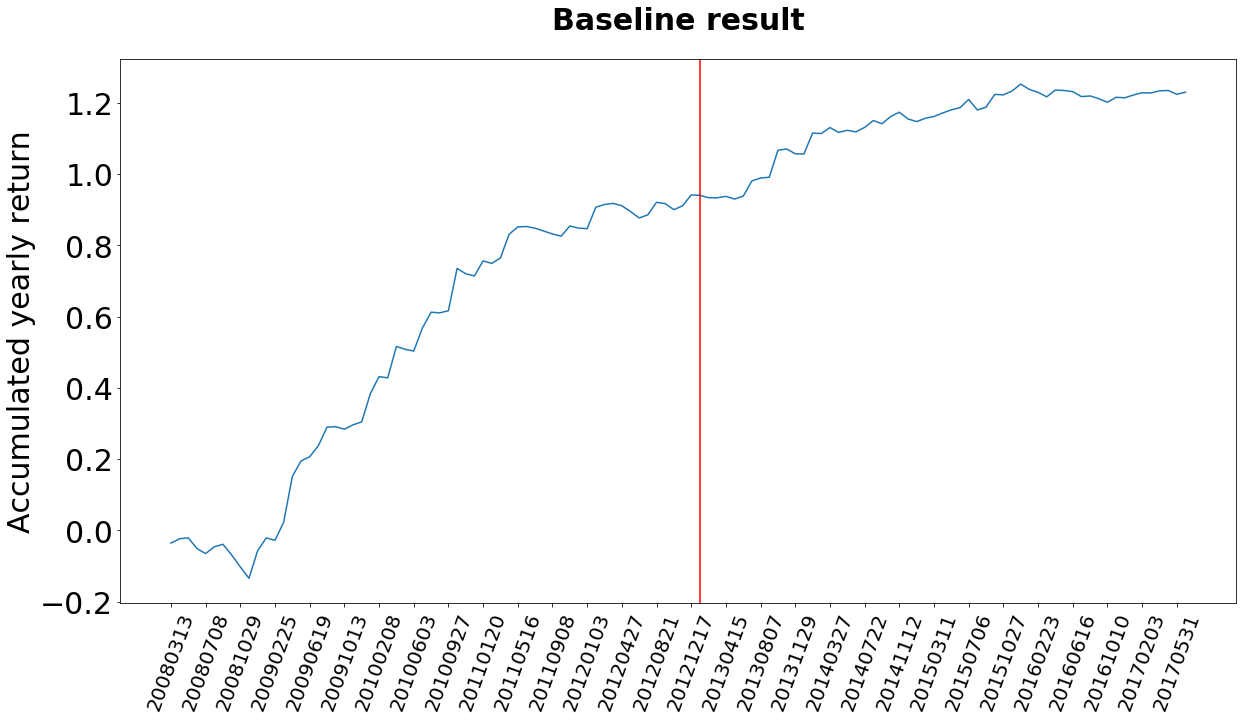

,Year,Return,Sharpe
0,2008,-0.056674,-0.692299
1,2009,0.361200,3.676245
2,2010,0.409331,3.224571
3,2011,0.134093,2.118230
4,2012,0.092953,1.429364
5,2013,0.114847,1.680922
6,2014,0.098261,1.818474
7,2015,0.097750,2.223340
8,2016,-0.038390,-1.367387
9,2017,0.015641,1.587530


In [42]:
a3=back_test(tt,q=0.90,flag="flag2",ret="ret_20_raw",Alp="Alp")
summary_return_sharpe(a3[2],12)

### Random Forest Result

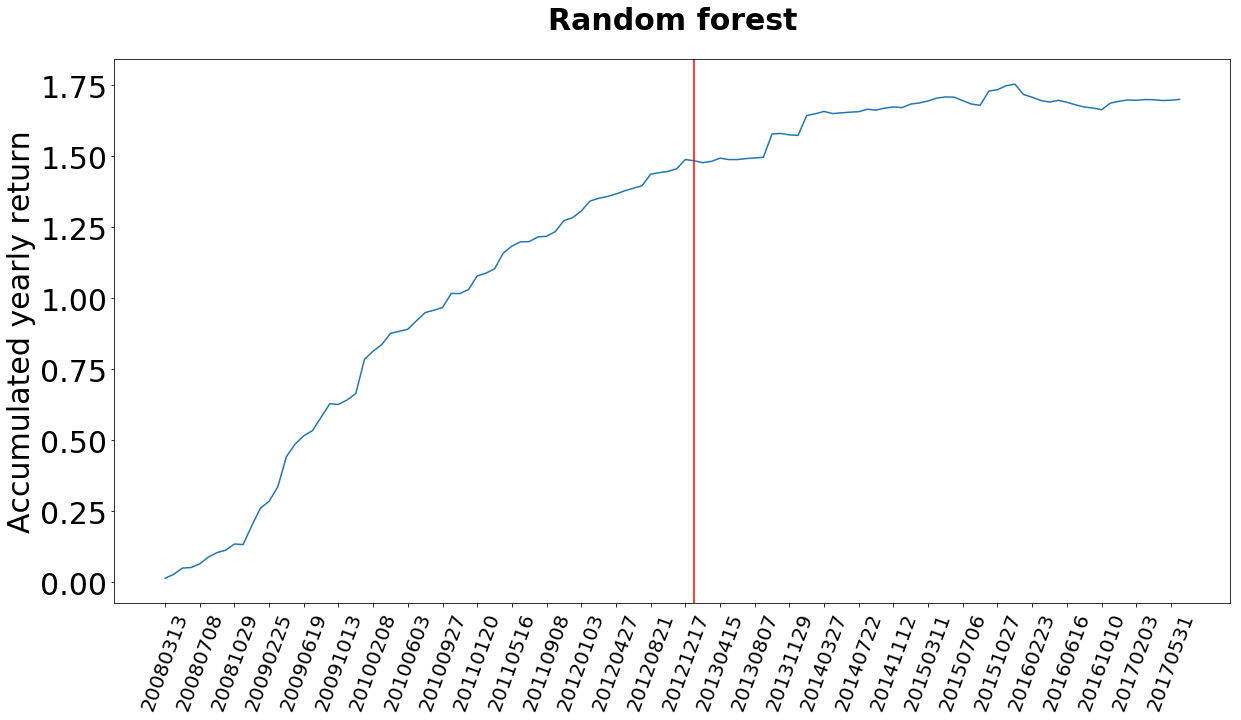

,Year,Return,Sharpe
0,2008,0.199600,4.654672
1,2009,0.465463,6.327644
2,2010,0.366234,4.120010
3,2011,0.252835,5.558153
4,2012,0.204690,5.753753
5,2013,0.084900,1.294486
6,2014,0.097934,1.860062
7,2015,0.082738,1.887559
8,2016,-0.060479,-1.658501
9,2017,0.006680,1.662077


In [89]:
a4=back_test(RF,q=0.90,flag="flag2",ret="ret_20_raw",Alp="Alp")
summary_return_sharpe(a4[2],12)

### Deep Learning Model

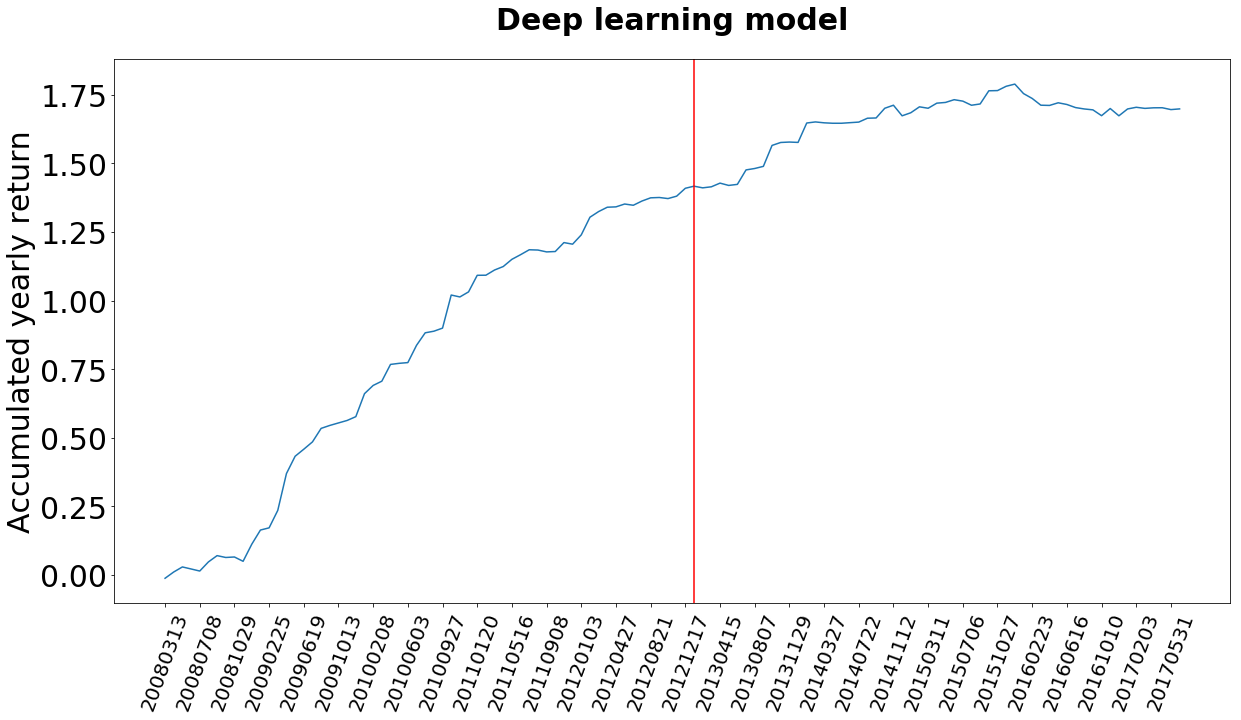

,Year,Return,Sharpe
0,2008,0.112119,1.942865
1,2009,0.465010,4.805855
2,2010,0.454794,4.241634
3,2011,0.173923,3.438949
4,2012,0.203762,3.840502
5,2013,0.167185,2.433415
6,2014,0.096976,1.435444
7,2015,0.115605,2.608061
8,2016,-0.115591,-2.614055
9,2017,0.025171,1.593722


In [93]:
a5=back_test(DNN,q=0.90,flag="flag2",ret="ret_20_raw",Alp="Alp")
summary_return_sharpe(a5[2],12)